In [1]:
import re
from urllib import request
from bs4 import BeautifulSoup
from snscrape.modules.twitter import TwitterTweetScraper, TwitterTweetScraperMode

USER_AGENT = 'oryx-scraper/0.0.1'
TIMEOUT = 5
ORYX_URL = 'https://www.oryxspioenkop.com/2022/11/tracking-threat-russias-izdeliye-305.html'

In [2]:
headers = {
    'User-Agent': USER_AGENT,
    'Accept-Language': 'en-US,en',
}
req = request.Request(
    url=ORYX_URL,
    headers=headers,
    method='GET',
)
res = request.urlopen(
    req,
    timeout=TIMEOUT,
).read()

In [3]:
soup = BeautifulSoup(res, 'html.parser')
post = soup.find('div', {'class': 'post'}).find('article')
all_links = post.find_all('a', string=re.compile('\(.*\)'))

In [4]:
# all_links[7].__dict__
# all_links[7].text

In [5]:
def extract_twitter_id(url):
    return url.split('://')[-1].split('/status/')[-1].split('/')[-1]

mode = TwitterTweetScraperMode.SINGLE

def extract_date(link):
    tweet_id = extract_twitter_id(link)
    tweet = next(TwitterTweetScraper(
        tweet_id,
        mode=mode
    ).get_items())
    return tweet.date

def process_links(elements):
    for elm in elements:
        amount = len(re.findall('(\d+)[, ]?', elm.text))
        link = elm.get('href')
        date = extract_date(link)
        for i in range(amount):
            yield [date, link]

In [6]:
# This is a bit slow since it does dozens of network calls
dates = list(process_links(all_links))

In [7]:
import json
json.dump(dates, open('lmur.json', 'w'), indent=4, default=str)

In [8]:
import pandas as pd
df = pd.DataFrame(dates).rename(columns={0: 'date', 1: 'url'})

In [9]:
df = df.assign(amount=1)
monthly = df.groupby(df['date'].dt.month)['amount'].sum()

In [10]:
monthly

date
6      6
7     22
8      9
9      4
10     8
11     1
Name: amount, dtype: int64

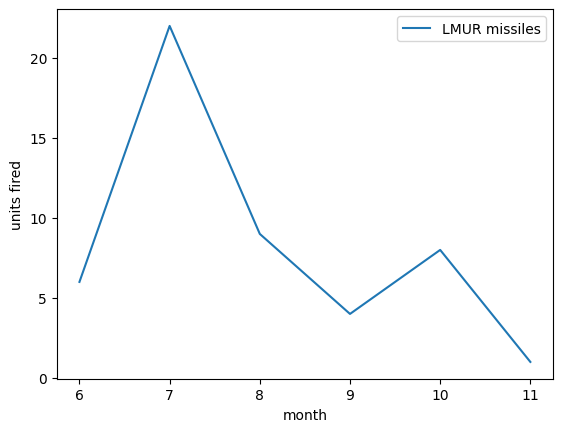

In [14]:
import matplotlib.pyplot as plt
plt.xlabel('month')
plt.ylabel('units fired')
plt.plot(monthly, label='LMUR missiles')
plt.legend()

In [15]:
plt.savefig('lmur.png')

<Figure size 640x480 with 0 Axes>